In [1]:
import numpy as np
# generate SEM
import sys
sys.path.append("..")
import scipy.stats as scistats
from notears.notears.notears import linear
from notears.notears.notears import utils
import helper.helper as h
import helper.methods as m
from timeit import default_timer as timer
from importlib import reload  # Python 3.4+
reload(linear)
import matplotlib.pyplot as plt

In [2]:
utils.set_random_seed(1)

n, d, s0, graph_type, sem_type = 50, 5, 5, 'ER', 'gauss'
print(f"SEM based on a graph on {d} nodes and {s0} edges, {n} samples.")

B_true = utils.simulate_dag(d, s0, graph_type)
print(f"Original Adjacency Matrix:\n{B_true}.\n")

W_true = utils.simulate_parameter(B_true)
print(f"Original WAM:\n{np.round(W_true, 1)}.\n")

X = utils.simulate_linear_sem(W_true, n, sem_type)

W_est, h_val = linear.notears_linear(X, lambda1=0.1, loss_type='l2-var', verbose = False)
print(f"Estimated WAM:\n{np.round(W_est, 1)}.\n")

acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)

SEM based on a graph on 5 nodes and 5 edges, 50 samples.
Original Adjacency Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]].

Original WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5 -1.9]
 [-1.9  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.1]
 [ 0.   0.  -0.9  0.   0. ]].

Estimated WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 2.3  0.  -0.4  0.   0.4]
 [-0.6  0.   0.   0.   0. ]
 [-1.1  0.   0.   0.   0. ]
 [ 0.3  0.   0.   0.   0. ]].

{'fdr': 0.6666666666666666, 'tpr': 0.4, 'fpr': 0.8, 'shd': 7, 'nnz': 6}


In [8]:
Ps = [16, 17, 18, 19, 20]

T = 100

r_NT = [[[] for _ in range(5)] for _ in range(len(Ps))]
r_OMP = [[[] for _ in range(5)] for _ in range(len(Ps))]

In [9]:
# numer of iterations
iters = 5

# number of different node sizes to try
for i, p in enumerate(Ps):
    
    print(f"{p}:", end = "\t")
    
    graph_type, sem_type = 'ER', 'gauss'
    s0 = int(min(2 * p, p * (p - 1) / 2))
    
    # number of iterations, more accurate results
    for j in range(iters):
        print(j, end = "\t")
    
        B_true = utils.simulate_dag(p, s0, graph_type)
        W_true = utils.simulate_parameter(B_true)
        X = utils.simulate_linear_sem(W_true, T, sem_type)
        
        ## NOTEARS
        notears_timer = timer()
        W_est, h_val = linear.notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False, w_threshold = 0.30)
        r_NT[i][0].append(timer() - notears_timer)
        
        # get accuracy
        acc = utils.count_accuracy(B_true, W_est != 0)
    
        # append results
        r_NT[i][1].append(acc['tpr'])
        r_NT[i][2].append(acc['fdr'])
        r_NT[i][3].append(acc['shd'])
        r_NT[i][4].append(h.MSE(W_est, X))
    
        ## OMP
        for _ in range(5):
            
            omp_timer = timer()
            W, r = m._K_OMP(X, X, F = [i * (p + 1) for i in range(p)], normalize = True, tol = 0)
            W[np.abs(W) <= 0.3] = 0
            r_OMP[i][0].append(timer() - omp_timer)

            acc = utils.count_accuracy(B_true, W != 0)

            r_OMP[i][1].append(acc['tpr'])
            r_OMP[i][2].append(acc['fdr'])
            r_OMP[i][3].append(acc['shd'])
            r_OMP[i][4].append(h.MSE(W, X))
            
            B_true = utils.simulate_dag(p, s0, graph_type)
            W_true = utils.simulate_parameter(B_true)
            X = utils.simulate_linear_sem(W_true, T, sem_type)
        
    print()

16:	0	1	2	3	4	
17:	0	1	2	3	4	
18:	0	1	2	3	4	
19:	0	1	2	3	4	
20:	0	1	2	3	4	


In [10]:
p_index = 2
m_index = 2

print(f"Showing mean scores for p = {Ps[p_index]}, Metric = ", end = "")
if m_index == 0: print("Time.")
elif m_index == 1: print("TPR.")
elif m_index == 2: print("FDR.")
elif m_index == 3: print("SHD.")
elif m_index == 4: print("MSE.")

print(f"OMP:\t{np.mean(np.array(r_OMP)[p_index][m_index])} +- {round(scistats.sem(np.array(r_OMP)[p_index][m_index]), 2)}.")
print(f"NOTEARS:{np.mean(np.array(r_NT)[p_index][m_index])} +- {round(scistats.sem(np.array(r_NT)[p_index][m_index]), 2)}.")

Showing mean scores for p = 6, Metric = FDR.
OMP:	0.1599058264967356 +- 0.0.
NOTEARS:0.03589077589077589 +- 0.01.


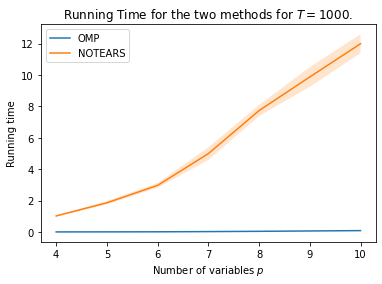

In [11]:
# Time
m_index = 0

plt.title("Running Time for the two methods for $T = 1000$.")

plt.xlabel(r"Number of variables $p$")
plt.ylabel(r"Running time")

plt.plot(Ps, np.mean(np.array(r_OMP)[:, m_index], axis = 1), label = "OMP")
plt.fill_between(Ps, np.mean(np.array(r_OMP)[:, m_index], axis = 1) - scistats.sem(np.array(r_OMP)[:, m_index], axis = 1), np.mean(np.array(r_OMP)[:, m_index], axis = 1) + scistats.sem(np.array(r_OMP)[:, m_index], axis = 1), alpha = 0.2)

plt.plot(Ps, np.mean(np.array(r_NT)[:, m_index], axis = 1), label = "NOTEARS")
plt.fill_between(Ps, np.mean(np.array(r_NT)[:, m_index], axis = 1) - scistats.sem(np.array(r_NT)[:, m_index], axis = 1), np.mean(np.array(r_NT)[:, m_index], axis = 1) + scistats.sem(np.array(r_NT)[:, m_index], axis = 1), alpha = 0.2)

plt.legend()

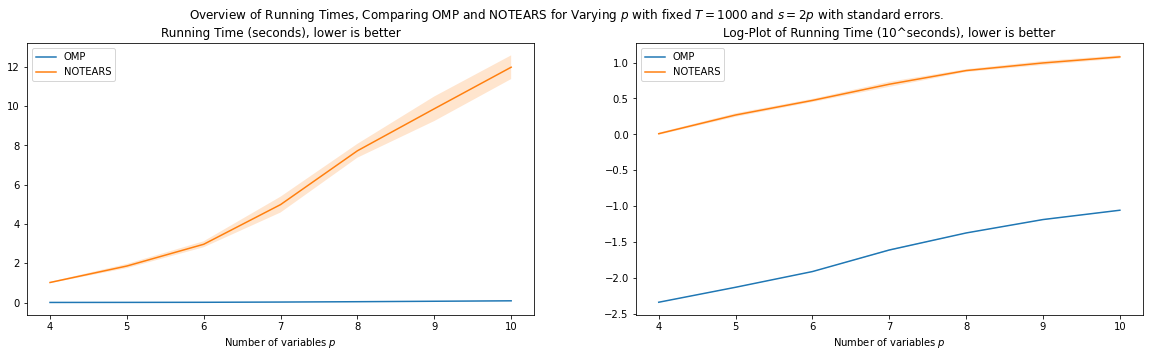

In [12]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle("Overview of Running Times, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = 2p$ with standard errors.")
titles = ['Running Time (seconds), lower is better', 'Log-Plot of Running Time (10^seconds), lower is better']

axs[0].plot(Ps, np.mean(np.array(r_OMP)[:, 0], axis = 1), label = "OMP")
axs[0].fill_between(Ps, np.mean(np.array(r_OMP)[:, 0], axis = 1) - scistats.sem(np.array(r_OMP)[:, 0], axis = 1), np.mean(np.array(r_OMP)[:, 0], axis = 1) + scistats.sem(np.array(r_OMP)[:, 0], axis = 1), alpha = 0.2)

axs[0].plot(Ps, np.mean(np.array(r_NT)[:, 0], axis = 1), label = "NOTEARS")
axs[0].fill_between(Ps, np.mean(np.array(r_NT)[:, 0], axis = 1) - scistats.sem(np.array(r_NT)[:, 0], axis = 1), np.mean(np.array(r_NT)[:, 0], axis = 1) + scistats.sem(np.array(r_NT)[:, 0], axis = 1), alpha = 0.2)

axs[1].plot(Ps, np.log10(np.mean(np.array(r_OMP)[:, 0], axis = 1)), label = "OMP")
axs[1].fill_between(Ps, np.log10(np.mean(np.array(r_OMP)[:, 0], axis = 1) - scistats.sem(np.array(r_OMP)[:, 0], axis = 1)), np.log10(np.mean(np.array(r_OMP)[:, 0], axis = 1) + scistats.sem(np.array(r_OMP)[:, 0], axis = 1)), alpha = 0.2)

axs[1].plot(Ps, np.log10(np.mean(np.array(r_NT)[:, 0], axis = 1)), label = "NOTEARS")
axs[1].fill_between(Ps, np.log10(np.mean(np.array(r_NT)[:, 0], axis = 1) - scistats.sem(np.array(r_NT)[:, 0], axis = 1)), np.log10(np.mean(np.array(r_NT)[:, 0], axis = 1) + scistats.sem(np.array(r_NT)[:, 0], axis = 1)), alpha = 0.2)

for i in range(2):
    axs[i].set_title(titles[i])
    axs[i].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')

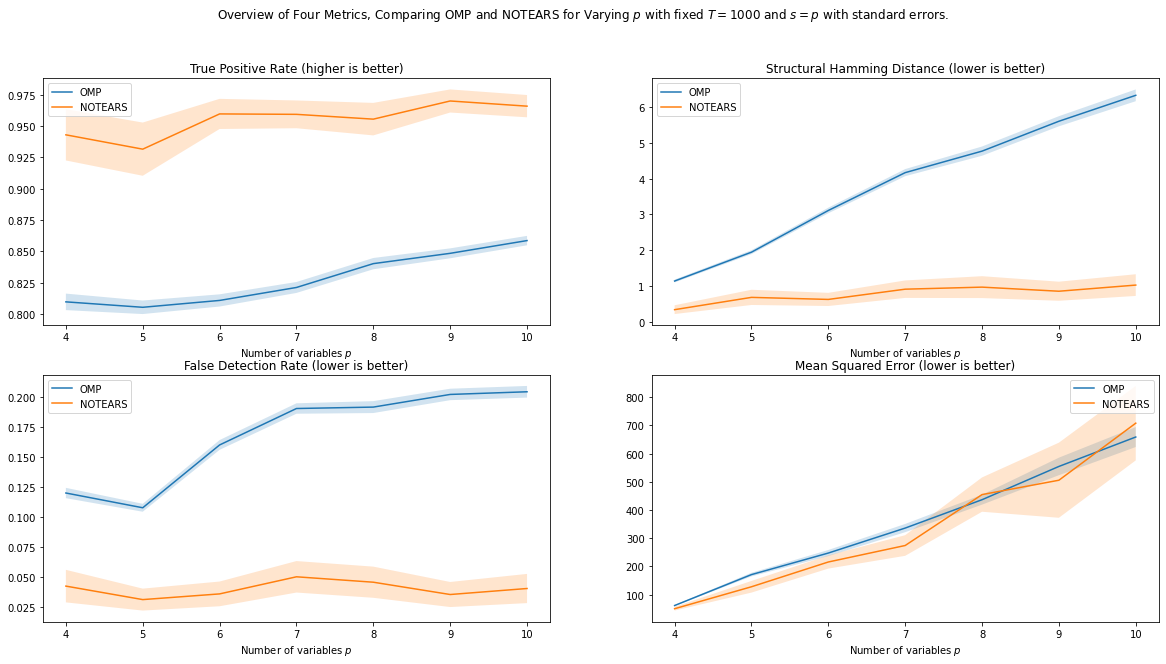

In [13]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle("Overview of Four Metrics, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Detection Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'Mean Squared Error (lower is better)']

for i in range(4):
    axs[i % 2, i // 2].plot(Ps, np.mean(np.array(r_OMP)[:, i + 1], axis = 1), label = "OMP")
    axs[i % 2, i // 2].fill_between(Ps, np.mean(np.array(r_OMP)[:, i + 1], axis = 1) - scistats.sem(np.array(r_OMP)[:, i + 1], axis = 1), np.mean(np.array(r_OMP)[:, i + 1], axis = 1) + scistats.sem(np.array(r_OMP)[:, i + 1], axis = 1), alpha = 0.2)

    axs[i % 2, i // 2].plot(Ps, np.mean(np.array(r_NT)[:, i + 1], axis = 1), label = "NOTEARS")
    axs[i % 2, i // 2].fill_between(Ps, np.mean(np.array(r_NT)[:, i + 1], axis = 1) - scistats.sem(np.array(r_NT)[:, i + 1], axis = 1), np.mean(np.array(r_NT)[:, i + 1], axis = 1) + scistats.sem(np.array(r_NT)[:, i + 1], axis = 1), alpha = 0.2)
    
    axs[i % 2, i // 2].set_title(titles[i])
    
    axs[i % 2, i // 2].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')